In [1]:
!pip install tqdm pyLDAvis gensim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from quickstart import get_data
service, messages = get_data()

In [9]:
import base64
import re
from tqdm import tqdm

def parse_email_digest(content):
    """ Returns a list of article information
        title, subtitle, author, publication, minutes (reading time)"""
    
    msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
    text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
    # print(text.encode('utf=8'))
    articles = [list(match) for match in re.findall('(.*)\r\n\r\n(.*)\r\n\r\n(.*) \r\n in (.*)\r\n*·(.*) min read', text, re.MULTILINE)]
    return articles

data = []
for message in tqdm(messages):
    # Get an email by id
    msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()

    # Get the email body
    content = msg['payload']['parts'][0]['body']['data']
    
    # Extract article information for all articles featured in daily digest
    for article in parse_email_digest(content):
        data.append(article)


100%|██████████| 500/500 [01:31<00:00,  5.48it/s]


In [11]:
import pandas as pd
df = pd.DataFrame(data, columns = ['Title', 'Subtitle', 'Author', 'Publication', 'Minutes'])
df['Minutes'] = df['Minutes'].astype(int)
df

,Title,Subtitle,Author,Publication,Minutes
0,3 Things Not to Do When Learning Data Science,Avoid them to reach your goal faster.,Soner Yıldırım,Towards Data Science,4
1,Top 10 Machine Learning Algorithms You Should ...,Nowadays businesses are focusing on automation...,Nora Winkens,Artificial Intelligence in Plain English,4
2,A simple way to export your Medium's reading l...,In a few lines of Python code,Eryk Lewinson,Geek Culture,5
3,Building a Plotly Dash App from Google Sheets ...,A non-traditional Dashboard built with well kn...,Derrick Lewis,Towards Data Science,10
4,Machine Learning | Sports Predictions,Let's start with an important question: What i...,Joe Sasson,Analytics Vidhya,6
...,...,...,...,...,...
1682,"Actually, Not a Ton of People Are Moving to Fl...",It turns out it's mostly tech moguls who have ...,Marker Editors,Marker,2
1683,Why We Should All Care About the Messy Busines...,Marker readers weigh in on the relevance of st...,Marker Editors,Marker,2
1684,Why the Pandemic Is Causing You Motivation Par...,It's time to reset your brain by being nice to it,Allison Hirschlag,The Bold Italic,5
1685,The Key to Achieving Your Goals Is Controlled ...,3 strategies for making mistakes you can learn...,Kristin Wong,Forge,5


<AxesSubplot:>

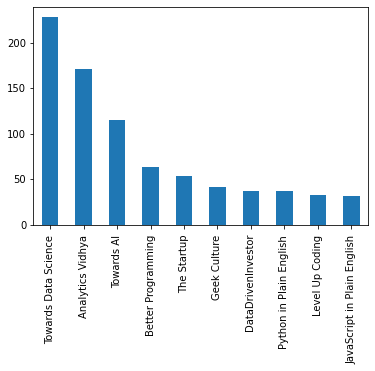

In [27]:
df['Publication'].value_counts().iloc[:10].plot.bar()

In [29]:
!pip install gensim

     |████████████████████████████████| 23.9 MB 12.1 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 6.7 MB/s eta 0:00:01


## Data Preprocessing

### Lemmatization and Stemming

In [30]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sejaldua/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [35]:
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [38]:
doc_sample = df['Title'].iloc[1]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\ntokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Top', '10', 'Machine', 'Learning', 'Algorithms', 'You', 'Should', 'Know', 'in', '2021']

tokenized and lemmatized document: 
['machin', 'learn', 'algorithm', 'know']


In [40]:
df['Titles_combined'] = df[['Title', 'Subtitle']].agg(' '.join, axis=1)
df[['Title', 'Subtitle', 'Titles_combined']].head()

,Title,Subtitle,Titles_combined
0,3 Things Not to Do When Learning Data Science,Avoid them to reach your goal faster.,3 Things Not to Do When Learning Data Science ...
1,Top 10 Machine Learning Algorithms You Should ...,Nowadays businesses are focusing on automation...,Top 10 Machine Learning Algorithms You Should ...
2,A simple way to export your Medium's reading l...,In a few lines of Python code,A simple way to export your Medium's reading l...
3,Building a Plotly Dash App from Google Sheets ...,A non-traditional Dashboard built with well kn...,Building a Plotly Dash App from Google Sheets ...
4,Machine Learning | Sports Predictions,Let's start with an important question: What i...,Machine Learning | Sports Predictions Let's st...


In [84]:
# processed_docs = df['Titles_combined'].map(preprocess)
processed_docs = df['Title'].map(preprocess)
processed_docs[:10]

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0                         [thing, learn, data, scienc]
1                     [machin, learn, algorithm, know]
2    [simpl, export, medium, read, list, markdown, ...
3                    [build, plot, dash, googl, sheet]
4                      [machin, learn, sport, predict]
5                                 [transform, pipelin]
6       [deep, learn, fraud, detect, retail, transact]
7                     [creat, predict, servic, python]
8       [scrap, tutori, airbnb, websit, scrapi, scrap]
9                [appl, upcom, massiv, septemb, event]
Name: Title, dtype: object

### Bag of Words

In [85]:
dictionary = gensim.corpora.Dictionary(processed_docs)
for k, v in list(dictionary.items())[:10]:
    print(k, v)

0 data
1 learn
2 scienc
3 thing
4 algorithm
5 know
6 machin
7 export
8 file
9 list


/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_doc_1 = bow_corpus[1]

for i in range(len(bow_doc_1)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_1[i][0], 
                                                     dictionary[bow_doc_1[i][0]], 
                                                     bow_doc_1[i][1]))


Word 1 ("learn") appears 1 time.
Word 3 ("algorithm") appears 1 time.
Word 4 ("know") appears 1 time.
Word 5 ("machin") appears 1 time.


/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### TF-IDF

In [87]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
print(corpus_tfidf[0])

[(0, 0.43639101195535224), (1, 0.5774775566529184), (2, 0.6899873594833161)]


/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Latent Dirichlet Allocation (LDA)

In [103]:
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary, passes=2, workers=4)

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.138*"work" + 0.125*"code" + 0.098*"panda" + 0.053*"python" + 0.052*"exampl" + 0.051*"effect" + 0.049*"trick" + 0.038*"dataset" + 0.035*"read" + 0.035*"react"
Topic: 1 Word: 0.100*"scrap" + 0.089*"creat" + 0.087*"machin" + 0.077*"data" + 0.067*"scienc" + 0.064*"learn" + 0.063*"text" + 0.058*"python" + 0.052*"classif" + 0.030*"generat"
Topic: 2 Word: 0.129*"scienc" + 0.100*"learn" + 0.075*"program" + 0.070*"data" + 0.060*"write" + 0.058*"deep" + 0.050*"explain" + 0.045*"imag" + 0.042*"machin" + 0.028*"beginn"
Topic: 3 Word: 0.093*"process" + 0.092*"languag" + 0.092*"natur" + 0.086*"book" + 0.057*"text" + 0.043*"read" + 0.038*"method" + 0.032*"data" + 0.027*"summar" + 0.023*"librari"
Topic: 4 Word: 0.141*"simpl" + 0.085*"time" + 0.063*"python" + 0.052*"probabl" + 0.051*"summar" + 0.045*"start" + 0.032*"tutori" + 0.031*"work" + 0.029*"visual" + 0.025*"data"
Topic: 5 Word: 0.150*"plot" + 0.125*"introduct" + 0.092*"python" + 0.065*"scienc" + 0.058*"tutori" + 0.053*"data" + 0

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(lda_model.num_topics))
viz_prep = True
if viz_prep:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(lda_model.num_topics) +'.html')
LDAvis_prepared

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.035068  0.210006       1        1  8.514203
8     -0.149537 -0.086865       2        1  7.863388
1     -0.029508  0.086256       3        1  7.789293
14     0.057140  0.153887       4        1  7.494687
3     -0.072191  0.040791       5        1  7.427903
7     -0.045980 -0.130411       6        1  7.277876
12     0.106016 -0.106696       7        1  7.210374
6     -0.114355 -0.083335       8        1  7.094204
9     -0.053245  0.055208       9        1  7.085473
0     -0.003972 -0.105074      10        1  6.960362
13     0.225771 -0.090878      11        1  6.375302
5      0.003363  0.017401      12        1  5.011569
11     0.143950  0.056796      13        1  4.723722
4      0.073391 -0.000806      14        1  4.603025
10    -0.105774 -0.016278      15        1  4.568617, topic_info=       Term        Freq       Total Category  logprob  loglift
15   python  128.000000  128.000000  Default  30.0000  30.0000
8     build   34.000000   34.000000  Default  29.0000  29.0000
40     guid   24.000000   24.000000  Default  28.0000  28.0000
1     learn   68.000000   68.000000  Default  27.0000  27.0000
48    model   35.000000   35.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
15   python    3.269479  128.767440  Topic15  -3.2555  -0.5874
4      know    1.060011   36.960086  Topic15  -4.3819  -0.4656
48    model    0.748079   35.071813  Topic15  -4.7304  -0.7617
21  process    0.610533   21.752314  Topic15  -4.9336  -0.4872
2    scienc    0.610600   51.352031  Topic15  -4.9335  -1.3461

[539 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3         1  0.040646  algorithm
3         4  0.731630  algorithm
3         5  0.040646  algorithm
3         7  0.081292  algorithm
3        13  0.040646  algorithm
...     ...       ...        ...
27       13  0.050071      write
28        2  0.121691       year
28        4  0.060845       year
28        5  0.060845       year
28       13  0.669299       year

[516 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 2, 15, 4, 8, 13, 7, 10, 1, 14, 6, 12, 5, 11])